In [44]:
import numpy as np
import pandas as pd

In [45]:
df = pd.read_csv("../data/bangkok_traffy.csv")

In [46]:
df = df.drop(['organization','comment','photo','photo_after','coords','address','star','count_reopen'],axis=1)

In [47]:
df = df[df['province'].str.contains('กรุงเทพ|bangkok',na=False,case=False)]

In [48]:
df = df.dropna(subset=['subdistrict', 'district'] )

In [49]:
df = df[df['state'].str.contains('เสร็จ',na=False,case=False)]

In [50]:
df.type.unique()

array(['{น้ำท่วม,ร้องเรียน}', '{สะพาน}', '{น้ำท่วม,ถนน}', ...,
       '{ถนน,จราจร,เสนอแนะ,ห้องน้ำ}',
       '{คนจรจัด,ความสะอาด,กีดขวาง,ทางเท้า,ร้องเรียน}',
       '{ถนน,ทางเท้า,PM2.5,ความปลอดภัย}'], dtype=object)

In [51]:
df[['subdistrict','district']]

,subdistrict,district
4,หนองบอน,ประเวศ
10,ยานนาวา,สาทร
25,ลาดพร้าว,ลาดพร้าว
64,ลาดพร้าว,ลาดพร้าว
102,ดุสิต,ดุสิต
...,...,...
270961,สีลม,บางรัก
270979,ทุ่งครุ,ทุ่งครุ
271016,ประเวศ,ประเวศ
271018,บางยี่ขัน,บางพลัด


In [52]:
df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)
df['last_activity'] = pd.to_datetime(df['last_activity'], utc=True)

In [53]:
# Extract the month of the year
df['month'] = df['timestamp'].dt.month

# Extract the year
df['year'] = df['timestamp'].dt.year

# Extract the quarter of the year
df['quarter'] = df['timestamp'].dt.quarter

# # Extract the day of the month
# df['day'] = df['timestamp'].dt.day

In [54]:
df.head()

,ticket_id,type,subdistrict,district,province,timestamp,state,last_activity,month,year,quarter
4,2021-CGPMUN,"{น้ำท่วม,ร้องเรียน}",หนองบอน,ประเวศ,กรุงเทพมหานคร,2021-09-19 14:56:08.924992+00:00,เสร็จสิ้น,2022-06-21 08:21:09.532782+00:00,9,2021,3
10,2021-7XATFA,{สะพาน},ยานนาวา,สาทร,กรุงเทพมหานคร,2021-09-26 05:03:52.594898+00:00,เสร็จสิ้น,2022-06-06 01:17:12.272904+00:00,9,2021,3
25,2021-DVEWYM,"{น้ำท่วม,ถนน}",ลาดพร้าว,ลาดพร้าว,กรุงเทพมหานคร,2021-12-09 12:29:08.408763+00:00,เสร็จสิ้น,2022-08-12 07:18:44.884945+00:00,12,2021,4
64,2021-4D9Y98,{},ลาดพร้าว,ลาดพร้าว,กรุงเทพมหานคร,2021-12-13 05:53:36.861064+00:00,เสร็จสิ้น,2023-03-14 12:09:14.947437+00:00,12,2021,4
102,2021-7U9RED,{},ดุสิต,ดุสิต,กรุงเทพมหานคร,2021-12-17 08:46:02.610983+00:00,เสร็จสิ้น,2022-06-01 03:16:34.479177+00:00,12,2021,4


In [55]:
df['time'] =  (df['last_activity'] - df['timestamp']).dt.days

In [56]:
type_con = df['type'].str.strip('{}').str.get_dummies(',')

In [57]:
df = pd.concat([df,type_con],axis=1)

In [58]:
district_hot =  pd.get_dummies(df['district'])
df = pd.concat([df,district_hot],axis=1)

In [59]:
subdistrict_oh =  pd.get_dummies(df['subdistrict'])
df = pd.concat([df,subdistrict_oh],axis=1)

In [60]:
df = df.drop(['ticket_id','type','subdistrict','district','province','timestamp','state','last_activity'],axis=1)

In [61]:
df[['time']].describe()

,time
count,202773.000000
mean,43.205284
std,69.637659
min,0.000000
25%,1.000000
50%,8.000000
75%,52.000000
max,464.000000


In [62]:
import seaborn as sns
# sns.kdeplot(data=df, x="time")

In [63]:
# Q1 = df['time'].quantile(0.25)
# Q3 = df['time'].quantile(0.75)
# IQR = Q3 - Q1
# df = df.query('(@Q1 - 1.5 * @IQR) <= time <= (@Q3 + 1.5 * @IQR)')

In [64]:
# sns.kdeplot(data=df, x="time")
df[['time']].describe()

,time
count,202773.000000
mean,43.205284
std,69.637659
min,0.000000
25%,1.000000
50%,8.000000
75%,52.000000
max,464.000000


In [65]:
selected_cols = ['time']
df = pd.concat([df[selected_cols], df.drop(columns=selected_cols)], axis=1)

In [66]:
df.head()

,time,month,year,quarter,PM2.5,การเดินทาง,กีดขวาง,คนจรจัด,คลอง,ความปลอดภัย,...,หิรัญรูจี,ห้วยขวาง,อนุสาวรีย์,อรุณอมรินทร์,ออเงิน,เสนานิคม,เสาชิงช้า,แสนแสบ,แสมดำ,โคกแฝด
4,274,9,2021,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,252,9,2021,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25,245,12,2021,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
64,456,12,2021,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
102,165,12,2021,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
from sklearn.model_selection import train_test_split

df_train, df_rem = train_test_split(df, test_size=0.3, random_state=123)

df_val, df_test = train_test_split(df_rem, test_size=0.5, random_state=123)


In [68]:
Q1 = df_train['time'].quantile(0.25)
Q3 = df_train['time'].quantile(0.75)
IQR = Q3 - Q1
df_train = df_train.query('(@Q1 - 1.5 * @IQR) <= time <= (@Q3 + 1.5 * @IQR)')

In [69]:
# len(df)*0.7

In [70]:
# len(df_train)

In [71]:
df_train[['time']].describe()

,time
count,123694.000000
mean,19.300039
std,29.196575
min,0.000000
25%,1.000000
50%,5.000000
75%,24.000000
max,128.000000


# Model

In [72]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tqdm import tqdm

class TabularDataset(Dataset):
    def __init__(self, dataframe, feature_scaler, target_scaler):
        self.data = dataframe.to_numpy()
        self.feature_scaler = feature_scaler
        self.target_scaler = target_scaler
        self.targets = self.target_scaler.transform(self.data[:, 0].reshape(-1, 1))
        self.features = self.feature_scaler.transform(self.data[:, 1:])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.tensor(self.features[idx], dtype=torch.float32)
        y = torch.tensor(self.targets[idx], dtype=torch.float32)
        return x, y

In [73]:
feature_scaler = MinMaxScaler()
feature_scaler.fit(df_train.iloc[:, 1:])

target_scaler = MinMaxScaler()
target_scaler.fit(df_train.iloc[:, 0].values.reshape(-1, 1))

MinMaxScaler()

In [74]:
train_dataset = TabularDataset(df_train, feature_scaler, target_scaler)
val_dataset = TabularDataset(df_val, feature_scaler, target_scaler)
test_dataset = TabularDataset(df_test, feature_scaler, target_scaler)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

c:\Users\pacha\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\pacha\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\pacha\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [75]:
import torch.nn as nn
import torch.nn.functional as F

class TabularModel(torch.nn.Module):
    def __init__(self, input_size):
        super().__init__()
        # self.fc1 = torch.nn.Linear(input_size, 256)
        # self.fc2 = torch.nn.Linear(256, 128)
        # self.fc3 = torch.nn.Linear(128, 1)
        # self.dropout = nn.Dropout(0.3)
        self.fc1 = torch.nn.Linear(input_size, 128)
        self.fc2 = torch.nn.Linear(128, 32)
        self.fc3 = torch.nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [76]:
train_dataset[0]

(tensor([0.4545, 0.0000, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         1.0000, 0.0000, 0.0

In [77]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [78]:
model = TabularModel(input_size=df_train.shape[1]-1).to(device)
# torch.compile(model)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [79]:
import matplotlib.pyplot as plt

EPOCHS = 5
train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    train_loss = 0.0
    for (inputs, targets) in tqdm(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    test_loss = 0.0
    for (inputs, targets) in tqdm(val_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()
    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}')

100%|██████████| 119/119 [00:00<00:00, 247.91it/s]


Epoch 1, Train Loss: 0.046441, Test Loss: 0.289223


100%|██████████| 119/119 [00:00<00:00, 257.02it/s]


Epoch 2, Train Loss: 0.044835, Test Loss: 0.288059


100%|██████████| 119/119 [00:00<00:00, 250.53it/s]


Epoch 3, Train Loss: 0.044077, Test Loss: 0.279353


100%|██████████| 119/119 [00:00<00:00, 259.26it/s]


Epoch 4, Train Loss: 0.043628, Test Loss: 0.287814


100%|██████████| 119/119 [00:00<00:00, 268.02it/s]

Epoch 5, Train Loss: 0.043208, Test Loss: 0.285363


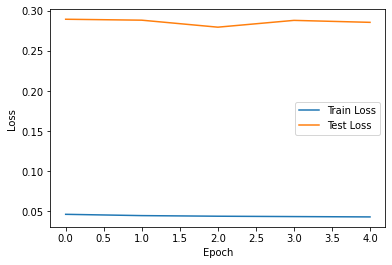

In [80]:
# Plotting the loss
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [81]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

import pandas as pd

def evaluate_model(model, dataloader, feature_scaler, target_scaler):
    criterion = torch.nn.MSELoss()
    model.eval()
    total_loss = 0.0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, targets in tqdm(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            y_true.extend(targets.cpu().numpy())
            y_pred.extend(outputs.cpu().numpy())
    
    # Inverse transform the scaled values
    y_true = target_scaler.inverse_transform(y_true)
    y_pred = target_scaler.inverse_transform(y_pred)
    
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    plt.figure(figsize=(20,10))
    plt.scatter(x = [i for i in range(0, len(y_pred))], y = y_pred, label = "predict")
    plt.scatter(x = [i for i in range(0, len(y_pred))], y = y_true, label = "true")
    plt.legend()
    plt.show()
    
    df = pd.DataFrame({'Actual': y_true.flatten(), 'Predicted': y_pred.flatten()})
    
    return mse, mae, rmse, df

100%|██████████| 1933/1933 [00:02<00:00, 749.52it/s]


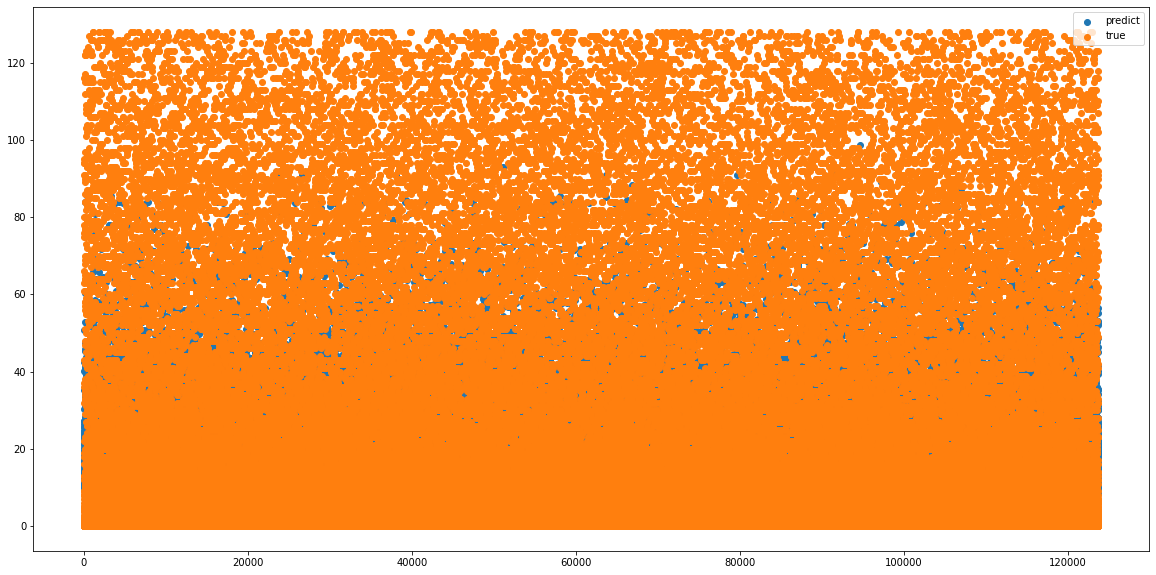

Train MSE: 691.6424
Train MAE: 19.9737
Train RMSE: 26.2991


,Actual,Predicted
0,0.0,17.018036
1,1.0,17.578989
2,4.0,16.796667
3,13.0,18.259546
4,0.0,16.514040


In [82]:
train_mse, train_mae, train_rmse, results_df = evaluate_model(model, train_loader, feature_scaler, target_scaler)
print(f'Train MSE: {train_mse:.4f}')
print(f'Train MAE: {train_mae:.4f}')
print(f'Train RMSE: {train_rmse:.4f}')

results_df.head()

100%|██████████| 119/119 [00:00<00:00, 187.70it/s]


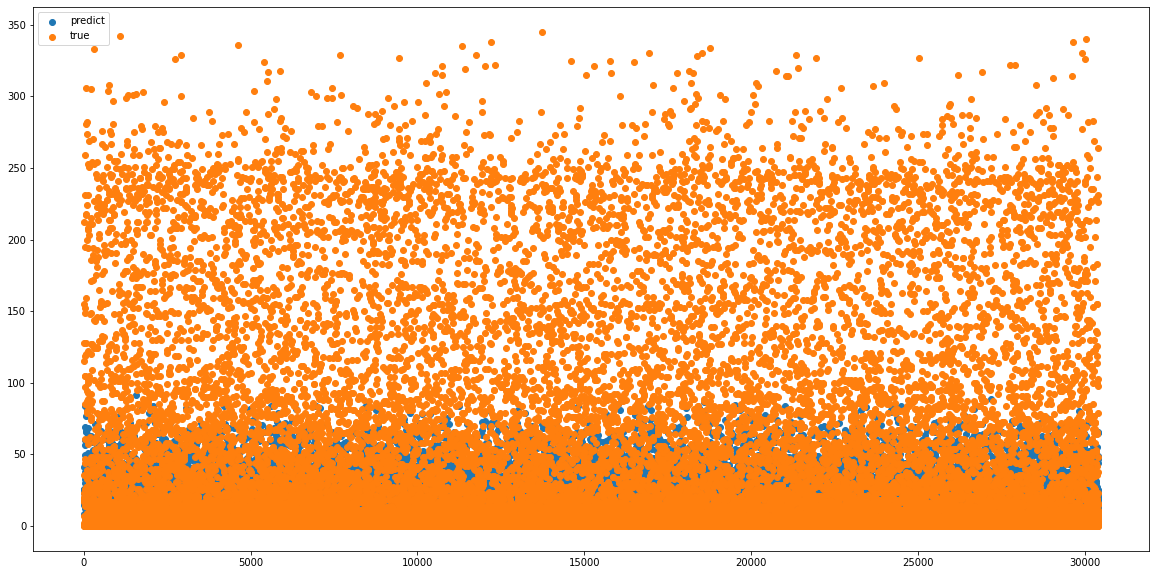

Test MSE: 4727.0148
Test MAE: 39.9768
Test RMSE: 68.7533


,Actual,Predicted
0,0.0,17.965298
1,212.0,23.983313
2,115.0,18.131594
3,1.0,17.838701
4,2.0,17.940733


In [83]:
# Usage:
test_mse, test_mae, test_rmse, results_df = evaluate_model(model, test_loader, feature_scaler, target_scaler)
print(f'Test MSE: {test_mse:.4f}')
print(f'Test MAE: {test_mae:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

results_df.head()  # Print the first few rows of the results DataFrame

In [84]:
results_df.describe()

,Actual,Predicted
count,30416.000000,30416.000000
mean,43.641537,23.282255
std,69.785929,11.001526
min,0.000000,4.438076
25%,1.000000,15.815237
50%,8.000000,22.025555
75%,53.000000,25.873879
max,345.000000,91.626778
